In [83]:
from skimage.draw import disk
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tf
folder = "/Users/surbhitwagle/Desktop/cell_1/"
image_f = "Composite 1.tif"
filename=folder+image_f
roi_f = folder + "Dendrite0.npy"
from skimage import feature
from skimage.filters import sobel,threshold_otsu,threshold_triangle,threshold_mean,gaussian
from skimage.morphology import erosion
from skimage.draw import line,polygon,ellipse,disk
from skimage.filters import try_all_threshold

In [2]:
def getAngle(u):
    root_axis = np.array([0,1])
    dp = root_axis.dot(u)
    angle = np.arccos(dp)
    return angle

In [90]:
def GetPerpendicularVector(a,b):
    u = a-b
    u_p = u/np.linalg.norm(u)

    d_p = np.array([[0, 1], [-1, 0]])
    return d_p.dot(u_p)

In [4]:
def GetCornerVertices(a, b,width):
    u = a-b
    u_p = u/np.linalg.norm(u)

    d_p = np.array([[0, 1], [-1, 0]])
    d_np = np.array([[0, -1], [1, 0]])

    v = d_p.dot(u_p)
    v_n = d_np.dot(u_p)
    # width = 70
    p1 = a + v*width
    p2 = a + v_n*width
    p3 = b + v_n*width
    p4 = b + v*width
    return [p1, p2, p3, p4]

In [5]:
def unitVector(a):
    return a/np.linalg.norm(a)

In [6]:
def Distance(x, y):
    """
    Return the distance between two points.
    """
#     print("x,y = ",x,y)
    d = x - y
    return np.sqrt(np.dot(d, d))

In [105]:
def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unitVector(v1)
    v2_u = unitVector(v2)
    return np.arccos(np.dot(v1_u, v2_u))
def angle_between2(p1, p2):
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return np.rad2deg((ang1 - ang2) % (2 * np.pi))

In [9]:
d_p = np.array([[0, 1], [-1, 0]])
d_np = -1*d_p
print(d_p,"\n",d_np)

[[ 0  1]
 [-1  0]] 
 [[ 0 -1]
 [ 1  0]]


In [10]:
def Sanitycheck(p1,sz):
#     print("p1,sz = ",p1,sz)
    if p1[1]>=sz[0]:
        p1[1] = sz[0]-1
    if p1[0] >= sz[1]:
        p1[0] = sz[1]-1
    return p1

In [11]:
z = np.zeros(10)
tz = np.ones(10)
step_filter = np.concatenate((z,tz))
print(step_filter)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [12]:
def GetAllpointsonPath(xys):
    # print(xys)
    points = np.array([xys[0]])
    # print(points.shape)
    for idx in range(xys.shape[0]-1):
        a = xys[idx]
        b= xys[idx+1]
        rr,cc = line(a[0],a[1],b[0],b[1])
        points = np.concatenate((points,(np.column_stack((rr,cc)))))
#     points = np.asarray(points)
#     new_array = [tuple(row) for row in points]
#     uniques = np.unique(new_array,axis=0)
    return points#np.asarray(uniques)

In [13]:
def multidim_intersect(arr1, arr2):
    arr1_view = arr1.view([('',arr1.dtype)]*arr1.shape[1])
    arr2_view = arr2.view([('',arr2.dtype)]*arr2.shape[1])
    intersected = np.intersect1d(arr1_view, arr2_view)
    return intersected.view(arr1.dtype).reshape(-1, arr1.shape[1])

In [14]:
def GetwidthVertices(img,point,v,width):
#     print(point,v*width)
    p1 = Sanitycheck(point+v*width,img.shape).astype(int)
#     p2 = Sanitycheck(point - v*width,img.shape).astype(int)
    rr,cc = line(point[1],point[0],p1[1],p1[0],)
    return rr.astype(int),cc.astype(int)

In [15]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

In [108]:
# possible_width = np.arange(1,500,1)
# print(possible_width)
# calls =0;
def SearchWidth(img,edges,p,degree,width,count):
#     calls += 1
#     print(p,width)
    rr, cc = ellipse(p[1], p[0], width, 1, rotation=degree,shape=img.shape)
    ps = edges[rr,cc]
    iix = np.where(edges[rr,cc]  == True)[0]

    if(iix.shape[0] > 1 or count > 60 or width >= img.shape[0]):
#         print(iix.shape[0],width)
        return width
#     if ii.shape[0] < 2:
    next_width = width*1.2
#         return BinarySearchWidth(img,edges,p,degree,mid)
#     else:
#         mid = (index) // 2
#         if mid == index:
#             return possible_width[index]
#         else:
    count += 1
    return SearchWidth(img,edges,p,degree,next_width,count)

def getWidthnew(img,roi,sigma):
    fig,(ax0,ax1) = plt.subplots(1, 2, figsize=(20, 12), sharex=True, sharey=True)
    edges1 = feature.canny(img,sigma=sigma)
#     return edges1
#     print("\n","*"*20,roi)
    
#     from skimage.draw import ellipse
#     img = np.zeros((10, 12), dtype=np.uint8)
    all_ps = GetAllpointsonPath(roi)
    ax0.plot(roi[:,0],roi[:,1],'ro-')
    i_img = np.zeros(img.shape)
    width_arr = np.zeros(all_ps.shape[0])
    degrees = np.zeros(all_ps.shape[0])
    old_edges = edges1
    perpendicula_vs = np.zeros(degrees.shape)
    for dxd,d in enumerate(all_ps[1:]):
#         print(dxd,roi[dxd-1],d)
        u_vector = GetPerpendicularVector(all_ps[dxd],d)
#         perpendicula_vs[dxd] = np.rad2deg(angle_between2(np.array([0,1]),u_vector))
        if angle_between2(np.array([0,1]),u_vector) > 180:
                degrees[dxd] =  -1*angle_between(np.array([0,1]),u_vector)
        else:
            degrees[dxd] =  angle_between(np.array([0,1]),u_vector)
#         print(degrees[dxd])
        starting_width = 1
        width_arr[dxd] = SearchWidth(img,edges1,all_ps[dxd],degrees[dxd],starting_width,0)
#         print(width)
        rr, cc = ellipse(all_ps[dxd][1], all_ps[dxd][0], width_arr[dxd], 2, rotation=degrees[dxd],shape=img.shape)
#         edges1[rr,cc] = 1
        ii = np.where(edges1[rr,cc]  == True)[0]
#         print(ii.shape)
        i_img[rr,cc] = edges1[rr,cc]
#         rr, cc = ellipse(all_ps[dxd][1], all_ps[dxd][0], 1, 100, rotation=180+degrees,shape=img.shape)
#         i_img[rr,cc] = edges1[rr,cc]
#         old_edges[rr,cc] = 1
        
    ax0.imshow(old_edges)
    ax1.imshow(i_img)
    fig,ax = plt.subplots(1, 1, figsize=(12, 12), sharex=True, sharey=True)
    plt.plot(perpendicula_vs)
    return width_arr,degrees
def plotWidth(img,points,widths,degrees):
    print(points.shape)
    fig,(ax0,ax1) = plt.subplots(1, 2, figsize=(20, 12), sharex=True, sharey=True)
    null_img = np.zeros(img.shape)
    ax0.imshow(img)
    for pdx,p in enumerate(points[:]):
        rr,cc = ellipse(p[1],p[0],widths[pdx],2,rotation=degrees[pdx-1],shape=img.shape)
        null_img[rr,cc] = 1
    combined = np.multiply(img,null_img)
    ax1.imshow(combined)

/Users/surbhitwagle/Desktop/cell_1/


<ipython-input-90-11594de198ab>:3: RuntimeWarning: invalid value encountered in true_divide
  u_p = u/np.linalg.norm(u)
<ipython-input-105-086d624540b5>:17: RuntimeWarning: invalid value encountered in double_scalars
  return np.rad2deg((ang1 - ang2) % (2 * np.pi))
/Users/surbhitwagle/opt/anaconda3/lib/python3.8/site-packages/skimage/draw/draw.py:117: RuntimeWarning: invalid value encountered in double_scalars
  rotation %= np.pi
/Users/surbhitwagle/opt/anaconda3/lib/python3.8/site-packages/skimage/draw/draw.py:38: RuntimeWarning: invalid value encountered in double_scalars
  rotation %= np.pi


(1023, 2)


/Users/surbhitwagle/opt/anaconda3/lib/python3.8/site-packages/skimage/draw/draw.py:117: RuntimeWarning: invalid value encountered in double_scalars
  rotation %= np.pi
/Users/surbhitwagle/opt/anaconda3/lib/python3.8/site-packages/skimage/draw/draw.py:38: RuntimeWarning: invalid value encountered in double_scalars
  rotation %= np.pi


(1023, 2)


/Users/surbhitwagle/opt/anaconda3/lib/python3.8/site-packages/skimage/draw/draw.py:41: RuntimeWarning: invalid value encountered in true_divide
  distances = ((r * cos_alpha + c * sin_alpha) / r_rad) ** 2 \


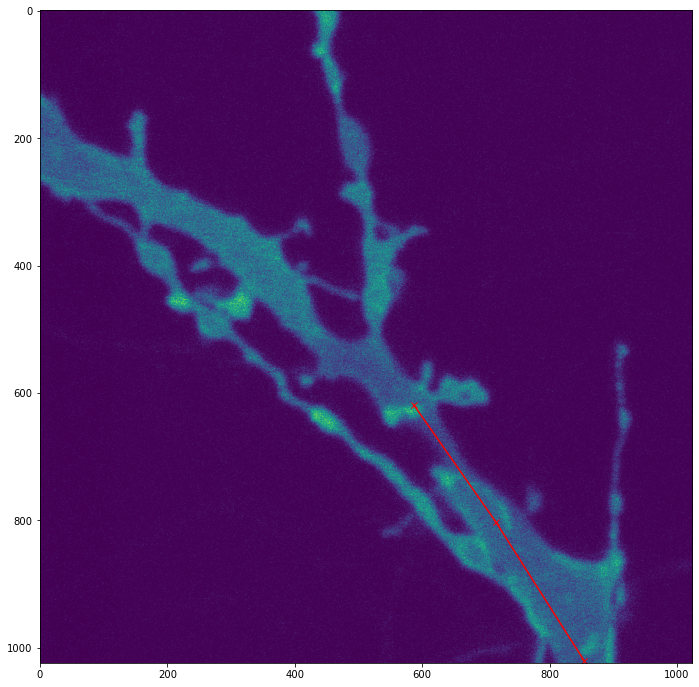

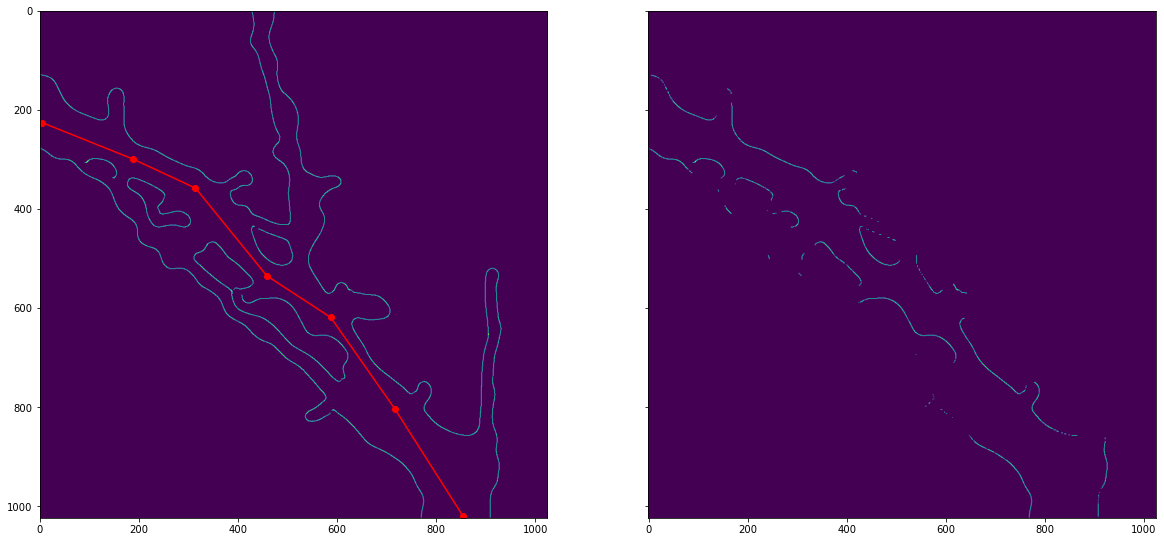

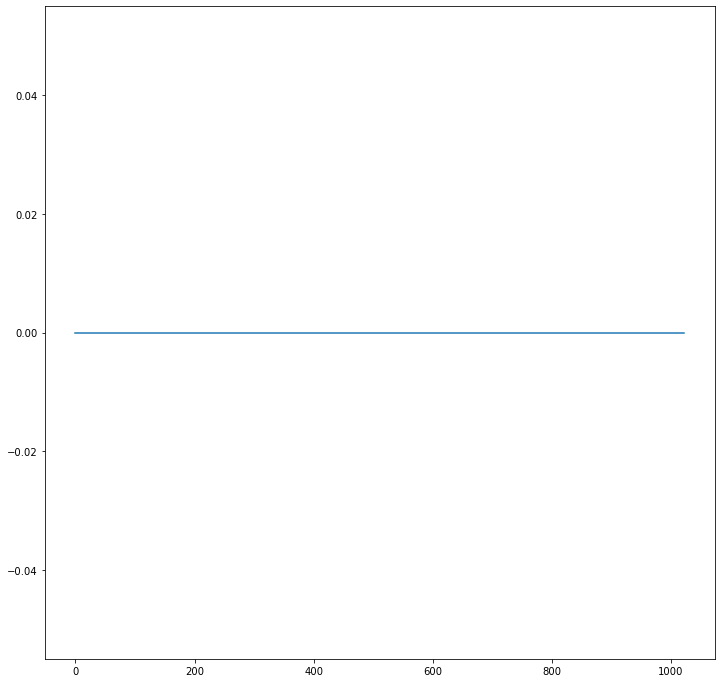

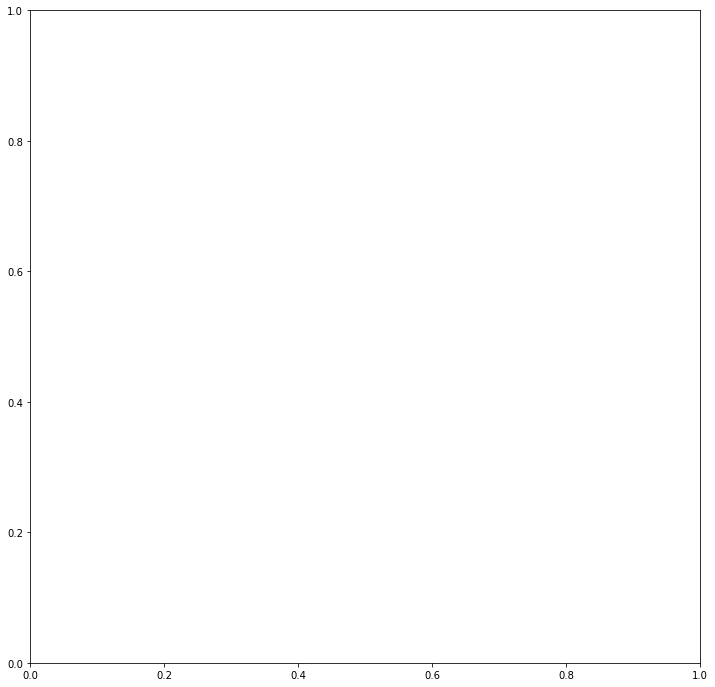

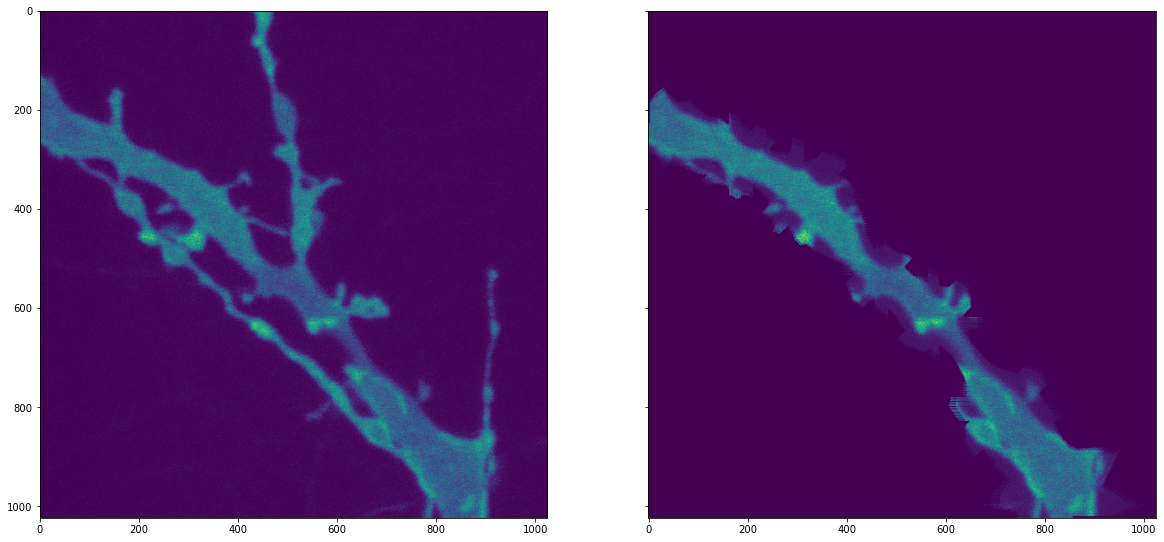

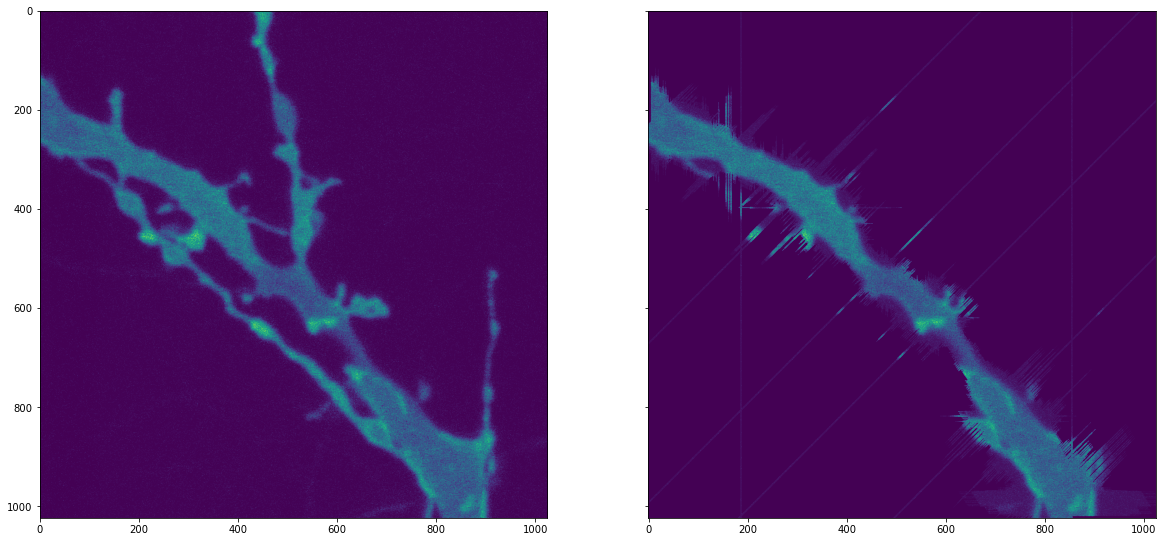

In [109]:
t_stack = tf.TiffFile(filename)
lsm_img = tf.imread(filename)
otsu_img = lsm_img[0] > threshold_mean(lsm_img[0])
# print(np.shape(otsu_img))
print(folder)
fig,ax = plt.subplots(1, 1, figsize=(12, 12), sharex=True, sharey=True)
plt.imshow(otsu_img)
plt.imshow(lsm_img[0])
dendArr = np.load(roi_f)
all_ps1 = GetAllpointsonPath(dendArr)
# dend_info = np.load(folder+"dend_info_0.npy")
# print(dendArr,"*"*29)
ax.plot(dendArr[0:3,0],dendArr[0:3,1],'rx-')
# denoisingImg(lsm_img[0],dendArr)
width_arr,degress = getWidthnew(otsu_img,dendArr,10) #dend_info[:,3],dend_info[:,4] #getWidthnew(otsu_img,dendArr,3)
avg_width = moving_average(width_arr,50) #dend_info[:,2]#moving_average(width_arr,50)
fig,ax = plt.subplots(1, 1, figsize=(12, 12), sharex=True, sharey=True)
# ax.plot(np.arange(0,width_arr.shape[0],1),width_arr,'r')
# ax.plot(np.arange(0,width_arr.shape[0],1),avg_width,'b')

# print(width)
plotWidth(lsm_img[0],all_ps1,avg_width,degress)
plotWidth(lsm_img[0],all_ps1,width_arr,degress)
# getWidth(lsm_img[0],dendArr,4)
# getWidth(otsu_img,dendArr,3)
# getWidth(lsm_img[0],dendArr,3)
# getWidth(otsu_img,dendArr,2)
# getWidth(otsu_img,dendArr,1)
# a = dendArr[0,:]
# b= dendArr[1,:]
# rr,cc = line(a[1],a[0],b[1],b[0])
# points = GetAllpointsonPath
# CheckEdgeNearby(lsm_img[0],(rr[200],cc[200]),a,b,dendArr)
# print(a,b)
plt.show()

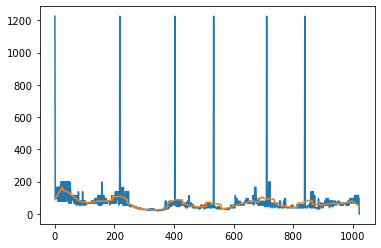

In [102]:
plt.plot(width_arr)
plt.plot(avg_width)
plt.show()

In [ ]:
dend_info = np.load(folder+"dend_info_0.npy")
print(folder)
print(dend_info)
print((width_arr.shape, dend_info[:,3].shape))
plt.plot(dend_info[:,3])
plt.plot(dend_info[:,2])
print(dendArr)
all_ps = GetAllpointsonPath(dendArr)
all_ps2 = GetAllpointsonPath(all_ps)
all_ps3 = GetAllpointsonPath(all_ps2)
print(all_ps.shape)
print(all_ps2.shape)
print(all_ps3.shape)

<ipython-input-90-11594de198ab>:3: RuntimeWarning: invalid value encountered in true_divide
  u_p = u/np.linalg.norm(u)
<ipython-input-105-086d624540b5>:17: RuntimeWarning: invalid value encountered in double_scalars
  return np.rad2deg((ang1 - ang2) % (2 * np.pi))
/Users/surbhitwagle/opt/anaconda3/lib/python3.8/site-packages/skimage/draw/draw.py:117: RuntimeWarning: invalid value encountered in double_scalars
  rotation %= np.pi
/Users/surbhitwagle/opt/anaconda3/lib/python3.8/site-packages/skimage/draw/draw.py:38: RuntimeWarning: invalid value encountered in double_scalars
  rotation %= np.pi


(998, 2)


/Users/surbhitwagle/opt/anaconda3/lib/python3.8/site-packages/skimage/draw/draw.py:117: RuntimeWarning: invalid value encountered in double_scalars
  rotation %= np.pi
/Users/surbhitwagle/opt/anaconda3/lib/python3.8/site-packages/skimage/draw/draw.py:38: RuntimeWarning: invalid value encountered in double_scalars
  rotation %= np.pi


(998, 2)


/Users/surbhitwagle/opt/anaconda3/lib/python3.8/site-packages/skimage/draw/draw.py:41: RuntimeWarning: divide by zero encountered in true_divide
  distances = ((r * cos_alpha + c * sin_alpha) / r_rad) ** 2 \
/Users/surbhitwagle/opt/anaconda3/lib/python3.8/site-packages/skimage/draw/draw.py:41: RuntimeWarning: invalid value encountered in true_divide
  distances = ((r * cos_alpha + c * sin_alpha) / r_rad) ** 2 \


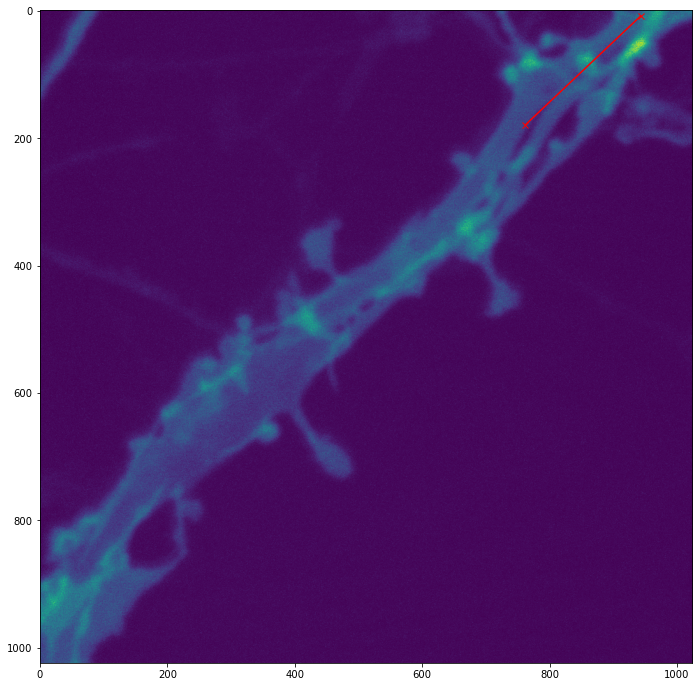

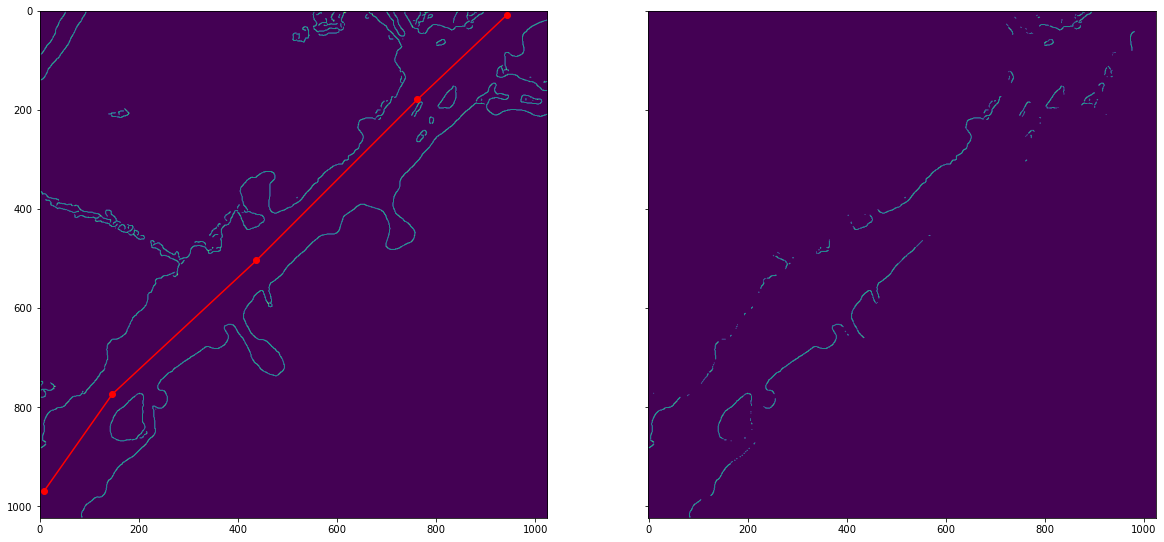

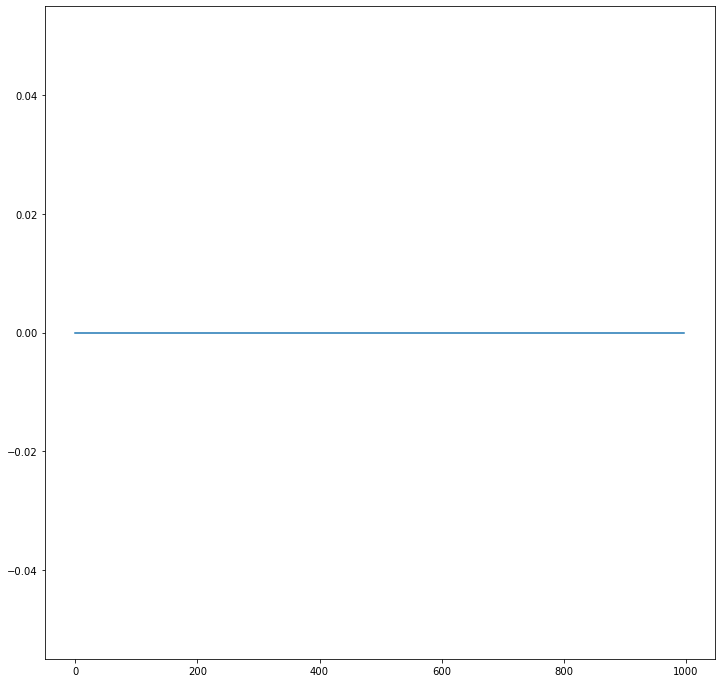

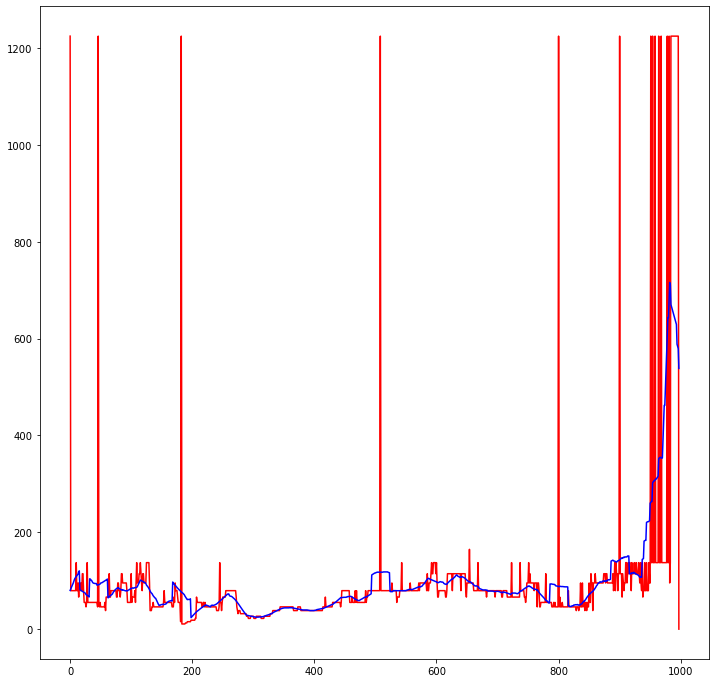

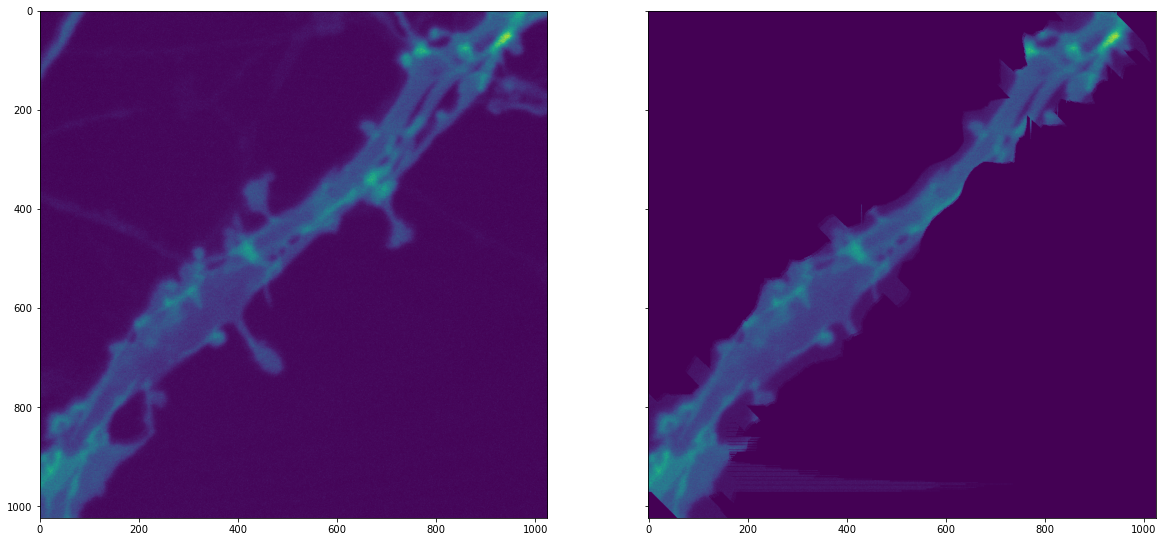

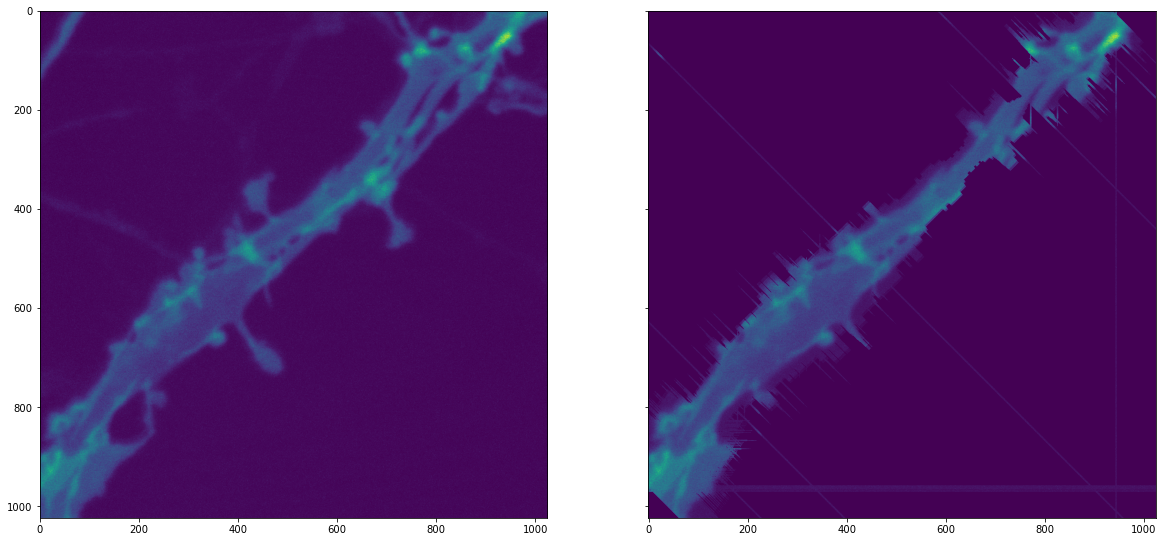

In [110]:
folder2 = "/Users/surbhitwagle/Desktop/cell_3/"
image_f2 = "Composite_1.tif"
filename2=folder2+image_f2
roi_f2 = folder2 + "Dendrite0.npy"
t_stack = tf.TiffFile(filename2)
lsm_img = tf.imread(filename2)
otsu_img = lsm_img[0] > threshold_mean(lsm_img[0])
# print(np.shape(otsu_img))
fig,ax = plt.subplots(1, 1, figsize=(12, 12), sharex=True, sharey=True)
plt.imshow(otsu_img)
plt.imshow(lsm_img[0])
dendArr = np.load(roi_f2)
# dendArr = np.flip(dendArr,axis=0)
# print(dendArr,"*"*29)
ax.plot(dendArr[0:2,0],dendArr[0:2,1],'rx-')
# denoisingImg(lsm_img[0],dendArr)
width_arr,degress = getWidthnew(otsu_img,dendArr,3)
avg_width = moving_average(width_arr,30)
fig,ax = plt.subplots(1, 1, figsize=(12, 12), sharex=True, sharey=True)
ax.plot(np.arange(0,width_arr.shape[0],1),width_arr,'r')
ax.plot(np.arange(0,width_arr.shape[0],1),avg_width,'b')
all_ps = GetAllpointsonPath(dendArr)
plotWidth(lsm_img[0],all_ps,avg_width,degress)
plotWidth(lsm_img[0],all_ps,width_arr,degress)

<ipython-input-90-11594de198ab>:3: RuntimeWarning: invalid value encountered in true_divide
  u_p = u/np.linalg.norm(u)
<ipython-input-105-086d624540b5>:17: RuntimeWarning: invalid value encountered in double_scalars
  return np.rad2deg((ang1 - ang2) % (2 * np.pi))
/Users/surbhitwagle/opt/anaconda3/lib/python3.8/site-packages/skimage/draw/draw.py:117: RuntimeWarning: invalid value encountered in double_scalars
  rotation %= np.pi
/Users/surbhitwagle/opt/anaconda3/lib/python3.8/site-packages/skimage/draw/draw.py:38: RuntimeWarning: invalid value encountered in double_scalars
  rotation %= np.pi


(1043, 2)


/Users/surbhitwagle/opt/anaconda3/lib/python3.8/site-packages/skimage/draw/draw.py:117: RuntimeWarning: invalid value encountered in double_scalars
  rotation %= np.pi
/Users/surbhitwagle/opt/anaconda3/lib/python3.8/site-packages/skimage/draw/draw.py:38: RuntimeWarning: invalid value encountered in double_scalars
  rotation %= np.pi


(1043, 2)


/Users/surbhitwagle/opt/anaconda3/lib/python3.8/site-packages/skimage/draw/draw.py:41: RuntimeWarning: divide by zero encountered in true_divide
  distances = ((r * cos_alpha + c * sin_alpha) / r_rad) ** 2 \
/Users/surbhitwagle/opt/anaconda3/lib/python3.8/site-packages/skimage/draw/draw.py:41: RuntimeWarning: invalid value encountered in true_divide
  distances = ((r * cos_alpha + c * sin_alpha) / r_rad) ** 2 \


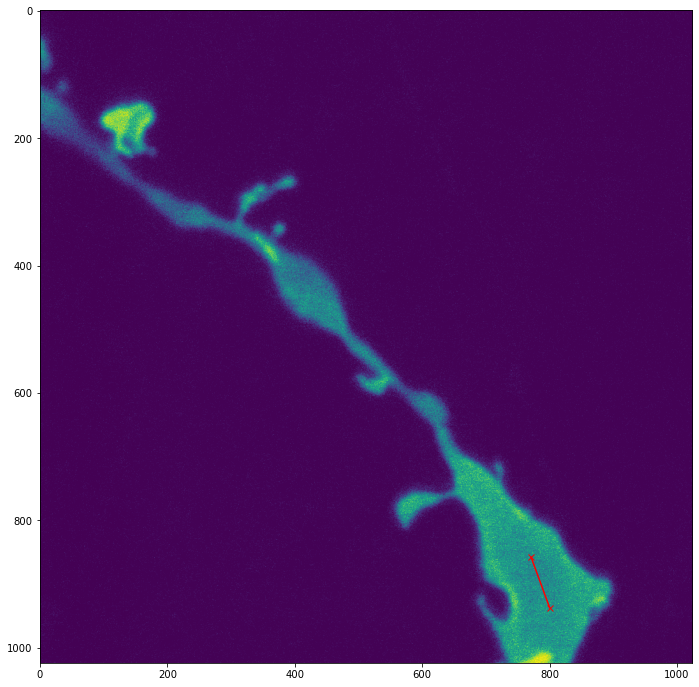

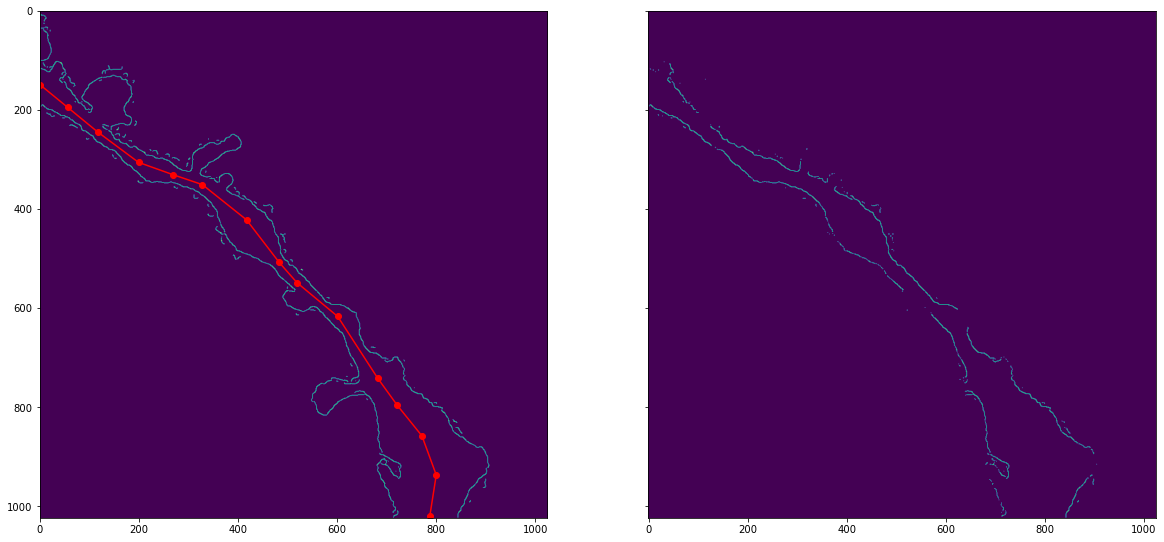

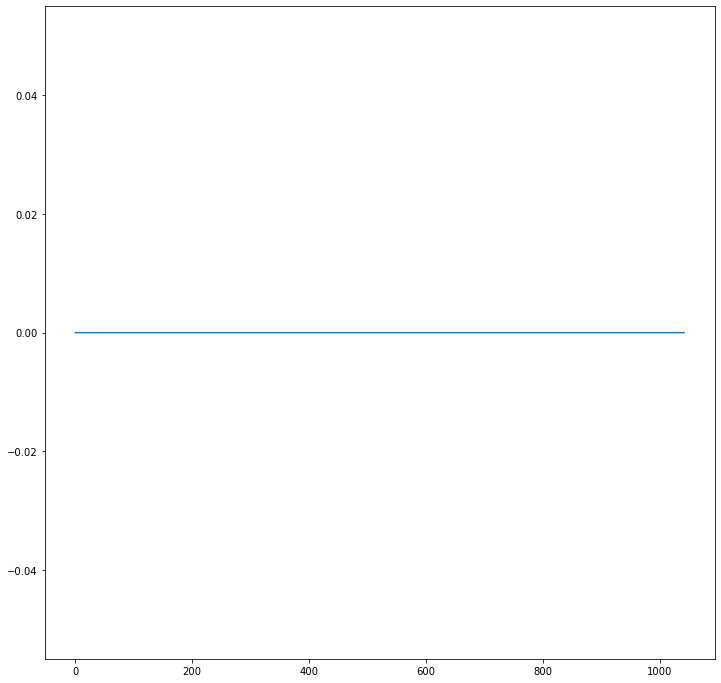

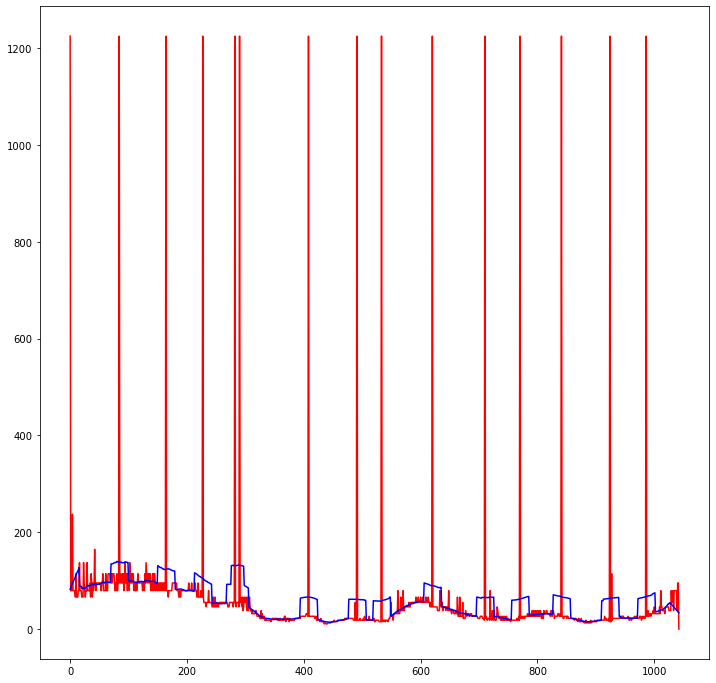

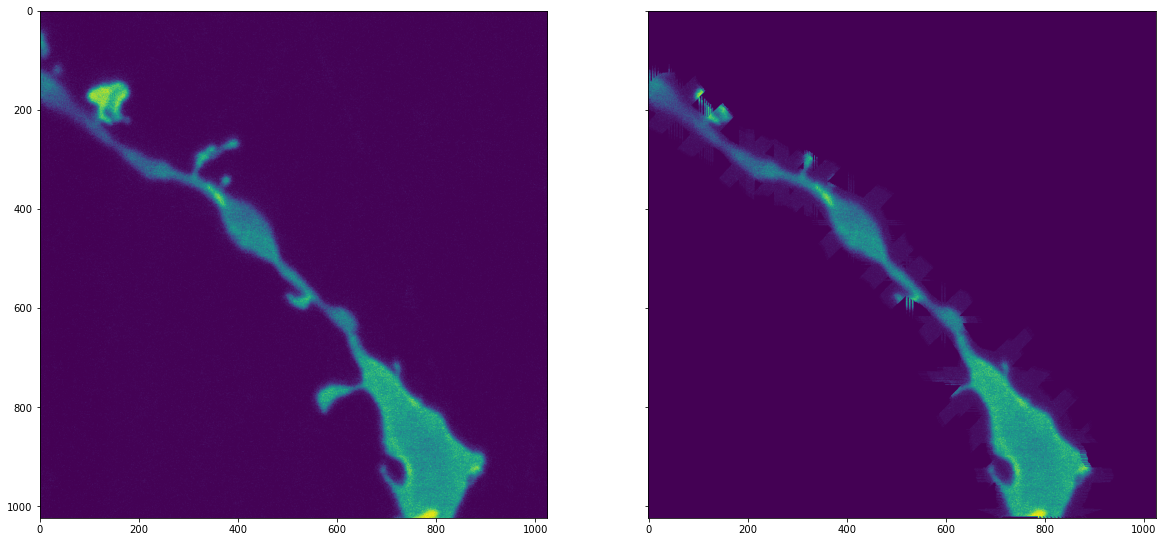

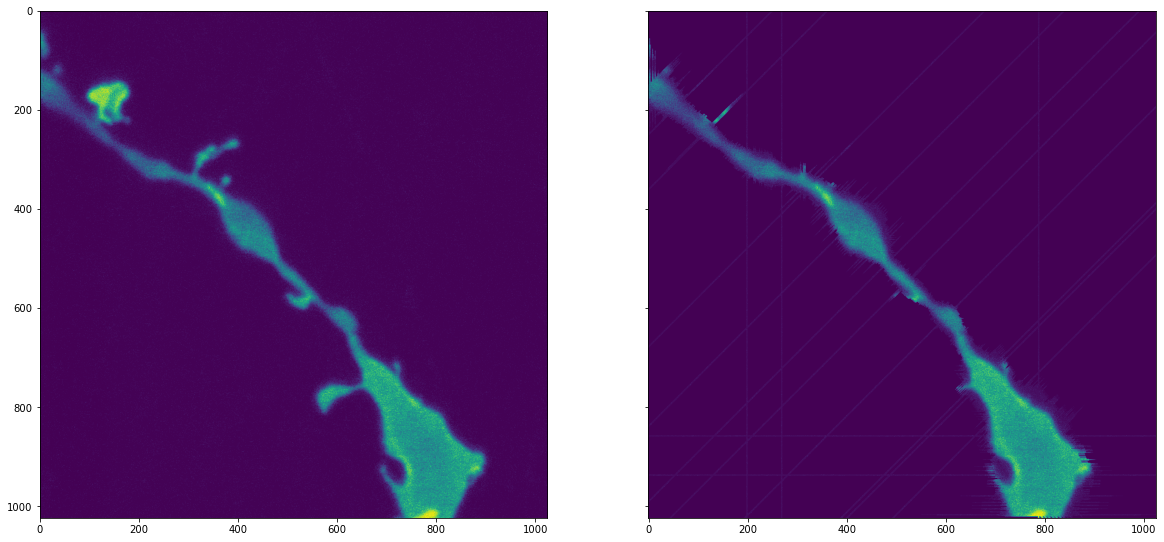

In [111]:
folder2 = "/Users/surbhitwagle/Desktop/cell_2/"
image_f2 = "Composite_2.tif"
filename2=folder2+image_f2
roi_f2 = folder2 + "Dendrite0.npy"
t_stack = tf.TiffFile(filename2)
lsm_img = tf.imread(filename2)
otsu_img = lsm_img[0] > threshold_mean(lsm_img[0])
# print(np.shape(otsu_img))
fig,ax = plt.subplots(1, 1, figsize=(12, 12), sharex=True, sharey=True)
plt.imshow(otsu_img)
plt.imshow(lsm_img[0])
dendArr = np.load(roi_f2)
# print(dendArr,"*"*29)
ax.plot(dendArr[1:3,0],dendArr[1:3,1],'rx-')
# denoisingImg(lsm_img[0],dendArr)
width_arr,degress = getWidthnew(otsu_img,dendArr,3)
avg_width = moving_average(width_arr,30)
fig,ax = plt.subplots(1, 1, figsize=(12, 12), sharex=True, sharey=True)
ax.plot(np.arange(0,width_arr.shape[0],1),width_arr,'r')
ax.plot(np.arange(0,width_arr.shape[0],1),avg_width,'b')
all_ps = GetAllpointsonPath(dendArr)
plotWidth(lsm_img[0],all_ps,avg_width,degress)
plotWidth(lsm_img[0],all_ps,width_arr,degress)

In [ ]:
dendArr = np.load(roi_f)
# print(dendArr)
lsm_img = tf.imread(filename)
img=np.zeros(lsm_img[0].shape)
otsu_img = lsm_img[0] > threshold_mean(lsm_img[0])
edges = getWidth(otsu_img,dendArr,10)
print(edges)
all_ps = GetAllpointsonPath(dendArr)
print(all_ps[1:10,:],all_ps.shape)
width_arr = np.zeros(all_ps.shape[0]+20)
last_width = 0
count =0;
# print(all_ps.shape,dendArr.shape)
for idx,point in enumerate(all_ps[:-1]):
#     print(point,all_ps[idx+1])
    v = GetPerpendicularVector(point,all_ps[idx+1])
#     print("v = ",v)
#     allp = GetAllpointsonPath(np.asarray([point,dendArr[idx+1]]))
#     count += allp.shape[0]
#     for p in allp:
#     print("point ",point)
    rr,cc = GetwidthVertices(lsm_img[0],point,v,80)
    p_rr = edges[rr,cc]
    ii = np.where(p_rr  == True)[0]
#         print(ii)
    if ii.shape[0]>0:
        last_width = width
        width = Distance(np.asarray([rr[ii[0]],cc[ii[0]]]),np.asarray(p[1],p[0]))
    else:
        width = last_width
    width_arr[count] = width
    count+=1
#         count += 1
#         rr,cc = GetwidthVertices(lsm_img[0],p,v,width)
# print(count)
#         edges[rr,cc] = 1
width_arr = moving_average(width_arr,30)
count =0
for idx,point in enumerate(dendArr[:-1]):
    v = GetPerpendicularVector(point,dendArr[idx+1])
    allp = GetAllpointsonPath(np.asarray([point,dendArr[idx+1]]))
    for p in allp:
        rr,cc = GetwidthVertices(lsm_img[0],p,v,width_arr[count])
        count+=1
        edges[rr,cc] = 1
        
#         p_rr = edges[rr,cc]
#         ii = np.where(p_rr  == True)[0]
# #         print(ii)
#         try:
#             last_width = width
#             width = Distance(np.asarray([rr[ii[0]],cc[ii[0]]]),np.asarray(p[1],p[0]))
#         except:
#             width = last_width
#         width_arr[count] = width
#         count += 1
#         rr,cc = GetwidthVertices(lsm_img[0],p,v,width)
print(width_arr[0:300])
fig,ax = plt.subplots(1, 1, figsize=(12, 12), sharex=True, sharey=True)
plt.imshow(edges)
# plt.imshow(img)
ax.plot(dendArr[:,0],dendArr[:,1],'rx-')